In [84]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from utils.gtsrb_dataset import GTSRBDataset
from models.tsr_cnn import TSRNet
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm 

In [97]:
from utils.train_tsr import train_tsr
from models.tsr_cnn import TSRNet
from torch.utils.data import DataLoader
from torchvision import transforms

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Datasets & loaders
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_dataset = GTSRBDataset(csv_file="./data/Train.csv", root_dir="./data/", transform=transform)
test_dataset  = GTSRBDataset(csv_file="./data/Test.csv",  root_dir="./data/", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Train samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")
# Model
model = TSRNet(num_classes=43).to(device)

# Train
model, best_acc = train_tsr(model, train_loader, test_loader, device, num_epochs=5)


Train samples: 39209 | Test samples: 12630


Epoch 1/5: 100%|██████████| 613/613 [00:13<00:00, 46.34it/s]


Epoch [1/5] Loss: 0.5424 | Train Acc: 85.05%
 Test Accuracy: 90.36%
✅ Saved checkpoint: ./results/checkpoints/tsr_epoch1_acc90.pth


Epoch 2/5: 100%|██████████| 613/613 [00:14<00:00, 42.47it/s]


Epoch [2/5] Loss: 0.0631 | Train Acc: 98.34%
 Test Accuracy: 92.87%
✅ Saved checkpoint: ./results/checkpoints/tsr_epoch2_acc92.pth


Epoch 3/5: 100%|██████████| 613/613 [00:11<00:00, 52.26it/s]


Epoch [3/5] Loss: 0.0301 | Train Acc: 99.16%
 Test Accuracy: 92.88%
✅ Saved checkpoint: ./results/checkpoints/tsr_epoch3_acc92.pth


Epoch 4/5: 100%|██████████| 613/613 [00:12<00:00, 47.42it/s]


Epoch [4/5] Loss: 0.0247 | Train Acc: 99.25%
 Test Accuracy: 93.85%
✅ Saved checkpoint: ./results/checkpoints/tsr_epoch4_acc93.pth


Epoch 5/5: 100%|██████████| 613/613 [00:11<00:00, 54.87it/s]


Epoch [5/5] Loss: 0.0139 | Train Acc: 99.60%
 Test Accuracy: 90.91%
Training complete. Best accuracy: 93.85%


In [ ]:
from models.tsr_cnn import TSRNet
from utils.attack_eval import evaluate_clean, evaluate_fgsm, evaluate_pgd, evaluate_patch
from utils.attacks import train_adversarial_patch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load TSR model
model = TSRNet(num_classes=43).to(device)
ckpt = torch.load("results/checkpoints/tsr_best_model.pth", map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()

# Evaluate clean accuracy
clean_acc = evaluate_clean(model, test_loader, device)
print("Clean Accuracy:", clean_acc)

# FGSM
eps = 0.03
adv_acc, asr = evaluate_fgsm(model, test_loader, device, eps)
print(f"FGSM Adv Acc: {adv_acc:.2f}%, ASR: {asr:.2f}%")

# PGD
adv_acc, asr = evaluate_pgd(model, test_loader, device, eps, alpha=0.007, iters=10)
print(f"PGD Adv Acc: {adv_acc:.2f}%, ASR: {asr:.2f}%")

# Train and evaluate patch attack
patch = train_adversarial_patch(model, train_loader, device, num_epochs=1, patch_size=0.18, lr=0.05)
res = evaluate_patch(model, test_loader, patch, device, patch_size=0.18)
print("Patch attack eval:", res)


Device: cuda
Loaded checkpoint: epoch 3, acc 92.70783847980998
Clean Test Accuracy: 92.71%

FGSM Results (eps=0.03):
  Clean Accuracy: 92.71%
  Adversarial Accuracy: 42.22%
  Attack Success Rate (ASR): 54.46%


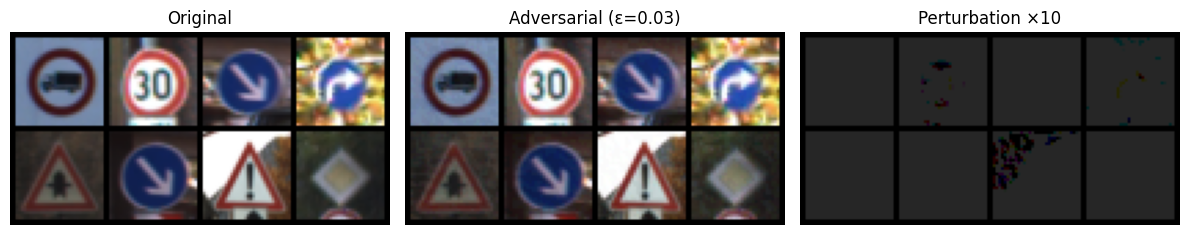


Running PGD (eps=0.03, alpha=0.007, iters=10)...
PGD Accuracy: 37.20%  |  Attack Success Rate: 59.88%
[Patch train] Epoch 1/1, loss: -3.6380
Saved patch to results/patch_trained.pt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.0].


Patch attack eval: {'clean_acc': 92.70783847980998, 'adv_acc': 64.72684085510689, 'asr': 31.14698095482108}


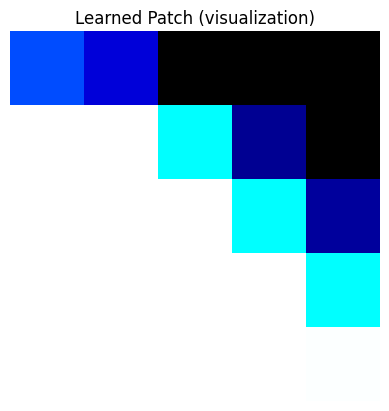

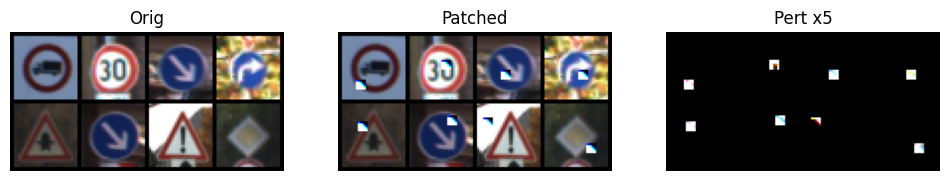

In [6]:
# ==================================================
# FGSM / PGD Attack Evaluation with ASR
# ==================================================
import torch
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from utils.attacks import fgsm_attack, pgd_attack
from utils.visualization import save_sample
from models.tsr_cnn import TSRNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# -----------------------------
# Load trained TSR model
# -----------------------------
ckpt_path = "./results/checkpoints/tsr_best_model.pth"
model = TSRNet(num_classes=43).to(device)
optimizer = torch.optim.Adam(model.parameters())

if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt['model_state_dict'])
    try:
        optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    except Exception:
        pass
    print(f"Loaded checkpoint: epoch {ckpt.get('epoch', '?')}, acc {ckpt.get('accuracy', '?')}")
else:
    raise FileNotFoundError("Checkpoint not found at " + ckpt_path)

model.eval()

# -----------------------------
# Helper: Evaluation Function
# -----------------------------
def evaluate(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    acc = 100.0 * correct / total
    return acc, torch.cat(all_preds), torch.cat(all_labels)

# -----------------------------
# Evaluate on Clean Data
# -----------------------------
clean_acc, clean_preds, clean_labels = evaluate(model, test_loader, device)
print(f"Clean Test Accuracy: {clean_acc:.2f}%")

# -----------------------------
# FGSM Attack
# -----------------------------
eps = 0.03  # attack strength
model.eval()
adv_correct, adv_total = 0, 0
correct_to_wrong = 0
original_correct = 0

for imgs, labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = torch.max(outputs, 1)
    # Count correctly classified samples
    correct_mask = (preds == labels)
    original_correct += correct_mask.sum().item()
    
    # Generate adversarial examples
    adv_imgs = fgsm_attack(model, imgs, labels, eps=eps, device=device)
    
    with torch.no_grad():
        adv_outputs = model(adv_imgs)
        _, adv_preds = torch.max(adv_outputs, 1)
    
    adv_correct += (adv_preds == labels).sum().item()
    adv_total += labels.size(0)
    
    # Count those flipped from correct → wrong
    correct_to_wrong += ((preds == labels) & (adv_preds != labels)).sum().item()

adv_acc = 100.0 * adv_correct / adv_total
attack_success_rate = 100.0 * correct_to_wrong / max(original_correct, 1)

print(f"\nFGSM Results (eps={eps}):")
print(f"  Clean Accuracy: {clean_acc:.2f}%")
print(f"  Adversarial Accuracy: {adv_acc:.2f}%")
print(f"  Attack Success Rate (ASR): {attack_success_rate:.2f}%")

# -----------------------------
# Visualization (Fixed for CUDA)
# -----------------------------
imgs_batch, labels_batch = next(iter(test_loader))
imgs_batch, labels_batch = imgs_batch.to(device), labels_batch.to(device)
adv_imgs_batch = fgsm_attack(model, imgs_batch, labels_batch, eps=eps, device=device)

def denorm(x):
    return torch.clamp(x * 0.5 + 0.5, 0, 1)  # inverse of normalization

orig = denorm(imgs_batch[:8])
adv = denorm(adv_imgs_batch[:8])
pert = (adv - orig).abs() * 10.0  # amplify perturbation

grid_orig = make_grid(orig.cpu(), nrow=4)
grid_adv = make_grid(adv.cpu(), nrow=4)
grid_pert = make_grid(pert.cpu(), nrow=4)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(np.transpose(grid_orig.numpy(), (1,2,0)))
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(np.transpose(grid_adv.numpy(), (1,2,0)))
axes[1].set_title(f"Adversarial (ε={eps})")
axes[1].axis("off")

axes[2].imshow(np.transpose(grid_pert.numpy(), (1,2,0)))
axes[2].set_title("Perturbation ×10")
axes[2].axis("off")

plt.tight_layout()
plt.show()


os.makedirs("results/sample_outputs", exist_ok=True)
save_sample(orig, "results/sample_outputs/original_grid.png")
save_sample(adv, "results/sample_outputs/adversarial_grid.png")
save_sample(pert, "results/sample_outputs/perturbation_grid.png")

# -----------------------------
# Optional PGD Attack
# -----------------------------
run_pgd = True  # toggle True to test PGD
if run_pgd:
    eps, alpha, iters = 0.03, 0.007, 10
    print(f"\nRunning PGD (eps={eps}, alpha={alpha}, iters={iters})...")
    pgd_correct, pgd_total, correct_to_wrong = 0, 0, 0
    original_correct = 0
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        correct_mask = (preds == labels)
        original_correct += correct_mask.sum().item()
        
        adv_imgs = pgd_attack(model, imgs, labels, eps=eps, alpha=alpha, iters=iters, device=device)
        with torch.no_grad():
            adv_outputs = model(adv_imgs)
            _, adv_preds = torch.max(adv_outputs, 1)
        pgd_correct += (adv_preds == labels).sum().item()
        pgd_total += labels.size(0)
        correct_to_wrong += ((preds == labels) & (adv_preds != labels)).sum().item()
    
    pgd_acc = 100.0 * pgd_correct / pgd_total
    pgd_asr = 100.0 * correct_to_wrong / max(original_correct, 1)
    print(f"PGD Accuracy: {pgd_acc:.2f}%  |  Attack Success Rate: {pgd_asr:.2f}%")


# -------------------------
# Train an adversarial patch
# -------------------------
from utils.attacks import train_adversarial_patch, evaluate_patch_attack, paste_patch
import matplotlib.pyplot as plt
from utils.visualization import save_sample

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# Use a small dataloader subset (faster)
subset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

patch = train_adversarial_patch(model, subset_loader, device,
                                num_epochs=1, lr=0.05, patch_size=0.18, target=None, init="random")

# visualize patch (denorm if needed)
patch_vis = (patch.clone() * 0.5 + 0.5).permute(1,2,0).numpy()  # if inputs normalized [-1,1]
plt.imshow(patch_vis)
plt.title("Learned Patch (visualization)")
plt.axis('off')

# save patch
import torch
torch.save(patch, "results/patch_trained.pt")
print("Saved patch to results/patch_trained.pt")

# -------------------------
# Evaluate patch attack on test set
# -------------------------
from utils.attacks import evaluate_patch_attack
patch = torch.load("results/patch_trained.pt")  # (C,Ph,Pw)
res = evaluate_patch_attack(model, test_loader, patch, device, patch_size=0.18)
print("Patch attack eval:", res)



# visualize a batch with patch pasted
imgs, labels = next(iter(test_loader))
imgs = imgs.to(device)
patched = paste_patch(imgs, patch.to(device), positions=None, scale=0.18)

# denorm helper
def denorm(x):
    return torch.clamp(x * 0.5 + 0.5, 0, 1)

orig = denorm(imgs[:8]).cpu()
pat = denorm(patched[:8]).cpu()
pert = (pat - orig).abs() * 5.0

from torchvision.utils import make_grid
g1 = make_grid(orig, nrow=4)
g2 = make_grid(pat, nrow=4)
g3 = make_grid(pert, nrow=4)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.transpose(g1.numpy(), (1,2,0))); plt.title("Orig"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(np.transpose(g2.numpy(), (1,2,0))); plt.title("Patched"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(np.transpose(g3.numpy(), (1,2,0))); plt.title("Pert x5"); plt.axis('off')
plt.show()


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from models.autoencoder import Autoencoder, save_checkpoint  # your file

# ----------------------------
# 1. Configuration
# ----------------------------
batch_size = 64
num_epochs = 5
latent_dim = 128
lr = 1e-3

# ----------------------------
# 2. Dataset & Dataloader
# ----------------------------


# ----------------------------
# 3. Model, Loss, Optimizer
# ----------------------------
model = Autoencoder(latent_dim=latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

ckpt_dir = "results/checkpoints/autoencoder"
os.makedirs(ckpt_dir, exist_ok=True)
best_test_loss = float("inf")

# -----------------------------
# Training loop
# -----------------------------


for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        z, x_rec = model(imgs)
        loss = criterion(x_rec, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)

    # -----------------------------
    # Evaluation on test set
    # -----------------------------
    model.eval()
    test_loss_total = 0
    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            z, x_rec = model(imgs)
            loss = criterion(x_rec, imgs)
            test_loss_total += loss.item() * imgs.size(0)
    test_loss = test_loss_total / len(test_loader.dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

    # -----------------------------
    # Save checkpoint if best
    # -----------------------------
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        ckpt_name = os.path.join(ckpt_dir, f"autoencoder_best.pth")
        save_checkpoint(model, optimizer, epoch+1, ckpt_name)
        print(f"✅ Saved best checkpoint at epoch {epoch+1}")

print("🎯 Training completed!")

Epoch [1/5] | Train Loss: 0.0587 | Test Loss: 0.0282
✅ Saved best checkpoint at epoch 1
Epoch [2/5] | Train Loss: 0.0241 | Test Loss: 0.0200
✅ Saved best checkpoint at epoch 2
Epoch [3/5] | Train Loss: 0.0177 | Test Loss: 0.0162
✅ Saved best checkpoint at epoch 3
Epoch [4/5] | Train Loss: 0.0146 | Test Loss: 0.0154
✅ Saved best checkpoint at epoch 4
Epoch [5/5] | Train Loss: 0.0131 | Test Loss: 0.0124
✅ Saved best checkpoint at epoch 5
🎯 Training completed!


In [63]:
# train_unet_watermark.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
import os
from models.autoencoder import Autoencoder
from models.unet_encoder import UNetWatermark


# -----------------------------
# Load pretrained Autoencoder
# -----------------------------
latent_dim = 128
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)
ae_ckpt = torch.load("results/checkpoints/autoencoder/autoencoder_best.pth", map_location=device)
autoencoder.load_state_dict(ae_ckpt["model_state"])
autoencoder.eval()
for param in autoencoder.parameters():
    param.requires_grad = False

# -----------------------------
# Initialize UNet
# -----------------------------
unet = UNetWatermark(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(unet.parameters(), lr=1e-4)

# -----------------------------
# VGG perceptual loss
# -----------------------------
vgg = models.vgg19(pretrained=True).features[:16].to(device).eval()
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(I, Iw):
    f1 = vgg(I)
    f2 = vgg(Iw)
    return torch.mean((f1 - f2)**2)

# -----------------------------
# Checkpoint folder
# -----------------------------
os.makedirs("checkpoints", exist_ok=True)

# -----------------------------
# Training loop
# -----------------------------
num_epochs = 10

for epoch in range(num_epochs):
    unet.train()
    running_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        # Get latent vector from pretrained autoencoder
        with torch.no_grad():
            z, _ = autoencoder(imgs)
        print("Latent z shape:", z.shape)
        # Generate watermarked image
        Iw = unet(imgs, z)

        # Compute perceptual loss
        loss = perceptual_loss(imgs, Iw)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    avg_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Perceptual Loss: {avg_loss:.6f}")

    # Save checkpoint
    torch.save(unet.state_dict(), f"checkpoints/unet_epoch_{epoch+1}.pth")
    print(f"✅ Saved checkpoint for epoch {epoch+1}")

print("🎯 UNet watermark training complete!")


/home/deepesh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deepesh/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8192 and 2048x128)